In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery

# Snce we don't have a dedicated function in the package to read the FX table (we only have one to write it),  
# we will use the BigQuery Client directly. It proves the Cloud Data Warehouse is actually working.

# 1. Setup - Force ID just to be safe in the notebook environment
PROJECT_ID = "projectbdm-487109"
DATASET = "patek_data"
TABLE = "fx_rates"
os.environ["GCP_PROJECT_ID"] = PROJECT_ID

print("⏳ Connecting to BigQuery to fetch FX rates...")
client = bigquery.Client()

# 2. Query
# We order by date to make sure the line chart connects points correctly
query = f"""
    SELECT date, base_currency, rate
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
    WHERE target_currency = 'EUR'
    ORDER BY date ASC
"""

df_fx = client.query(query).to_dataframe()

# 3. Clean Types (BigQuery sometimes sends dates as Objects)
df_fx['date'] = pd.to_datetime(df_fx['date'])
df_fx['rate'] = pd.to_numeric(df_fx['rate'])

print(f"✅ Loaded {len(df_fx)} daily rates.")
print(df_fx.head())

⏳ Connecting to BigQuery to fetch FX rates...
✅ Loaded 228 daily rates.
        date base_currency     rate
0 2020-08-29           CNY  0.12233
1 2020-08-29           SGD  0.61747
2 2020-08-29           EUR  1.00000
3 2020-08-29           USD  0.83928
4 2020-08-29           GBP  1.11770


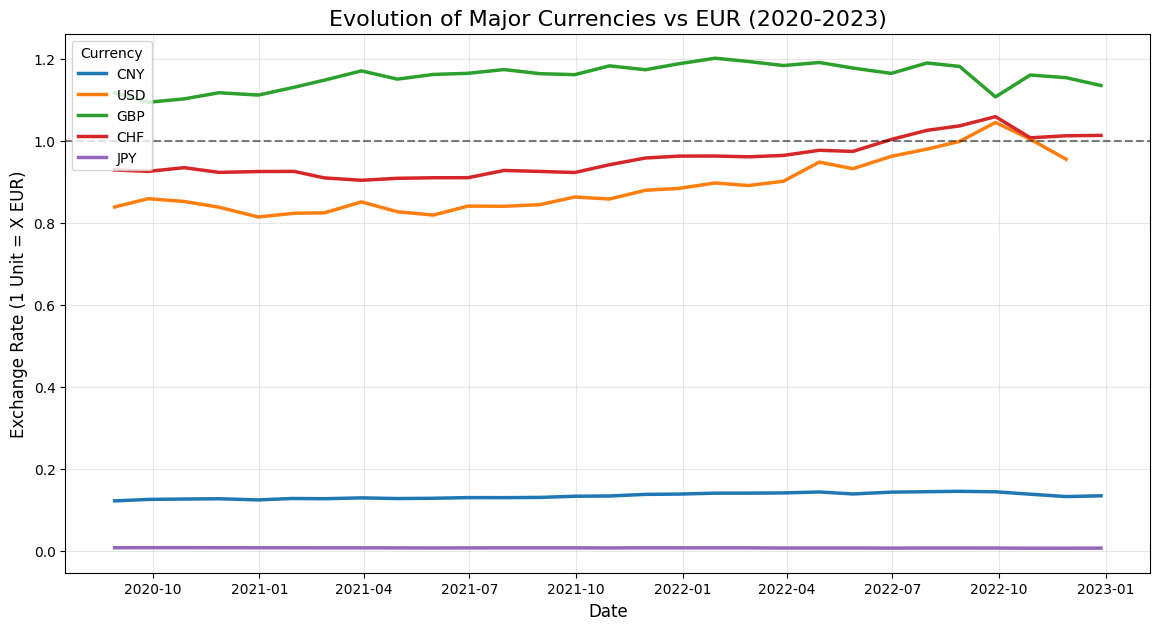

In [2]:
# 1. Filter for major currencies to keep the chart readable
major_currencies = ['USD', 'GBP', 'CHF', 'JPY', 'CNY']
df_subset = df_fx[df_fx['base_currency'].isin(major_currencies)].copy()

# 2. Plotting
plt.figure(figsize=(14, 7))

# We use 'hue' to automatically color lines by currency
sns.lineplot(data=df_subset, x='date', y='rate', hue='base_currency', linewidth=2.5)

# 3. Styling
plt.title("Evolution of Major Currencies vs EUR (2020-2023)", fontsize=16)
plt.ylabel("Exchange Rate (1 Unit = X EUR)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Currency", loc='upper left')

# Optional: Add a reference line for Parity (1.0)
plt.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Parity')

plt.show()